In this lesson, we will use the smartmeter data to train a forecasting algorithm, and test how well it works. 

# Step 1 - Loading libraries and data

In [1]:
import matplotlib.pyplot as plt #Matplotlib allows us to draw graphs
import numpy as np #Numpy allows us to perform complex mathematical processes quickly
import pandas as pd #Pandas is another useful set of tools for statistics
import datetime
from fbprophet import Prophet

In [2]:
energy = pd.read_csv('../input/schoolsmartmeterdata/meter-amr-readings-1200050359109 (3).csv')
energy.head()

,Reading Date,One Day Total kWh,Status,Substitute Date,00:30,01:00,01:30,02:00,02:30,03:00,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00
0,2018-01-01,1240.8,ORIG,NaN,22.3,21.9,21.9,22.3,22.5,21.3,...,25.4,25.5,27.3,25.3,22.3,21.6,21.7,22.4,21.8,22.3
1,2018-01-02,1252.9,ORIG,NaN,22.8,21.6,22.4,22.3,24.5,25.7,...,26.9,27.9,26.5,23.4,21.7,21.9,22.0,22.0,22.0,22.5
2,2018-01-03,1572.0,ORIG,NaN,22.0,22.2,22.5,21.6,22.1,22.1,...,26.5,24.6,24.6,23.1,21.3,21.0,21.2,21.2,21.0,20.6
3,2018-01-04,1500.8,ORIG,NaN,21.7,20.8,21.5,21.2,21.6,21.0,...,27.0,24.6,24.5,23.2,21.5,21.5,21.5,21.6,21.8,21.3
4,2018-01-05,1933.5,ORIG,NaN,21.4,21.3,21.5,21.6,21.4,21.4,...,25.7,25.2,24.7,23.1,22.5,20.6,20.1,20.7,20.6,20.5


The data has been read in successfully, but we need one column for the energy readings, rather than one per time point. We can use the 'melt' function to do this. 

In [3]:
energy = pd.melt(energy, id_vars=['Reading Date', 'One Day Total kWh', 'Status', 'Substitute Date'], var_name='Time', value_name="Energy")
energy.head()

,Reading Date,One Day Total kWh,Status,Substitute Date,Time,Energy
0,2018-01-01,1240.8,ORIG,NaN,00:30,22.3
1,2018-01-02,1252.9,ORIG,NaN,00:30,22.8
2,2018-01-03,1572.0,ORIG,NaN,00:30,22.0
3,2018-01-04,1500.8,ORIG,NaN,00:30,21.7
4,2018-01-05,1933.5,ORIG,NaN,00:30,21.4


Next, we need to turn the date and time columns into a datetime column for python to work with. 

In [4]:
energy['Timestamp'] = pd.to_datetime(energy['Reading Date'] + " " + energy['Time'], format='%Y-%m-%d %H:%M')
print('Start of data collection: ', energy['Timestamp'].min())
print('End of data collection: ', energy['Timestamp'].max())
energy = energy.sort_values(by=['Timestamp'])

Start of data collection:  2018-01-01 00:00:00
End of data collection:  2021-06-05 23:30:00


# Step 2 - Preparing the data for modelling

We need to break the data into training and testing, to see how well the forecasting algorithm works.

In [5]:
train_data = energy[['Timestamp', 'Energy']][(energy['Timestamp']> "2018-01-01") & (energy['Timestamp']< "2018-03-01")]
train_data.columns = ['ts', 'y']
test_data = energy[['Timestamp', 'Energy']][(energy['Timestamp']> "2018-03-01") & (energy['Timestamp']< "2018-05-01")]
test_data.columns = ['ts', 'y']

Text(0, 0.5, 'Energy use')

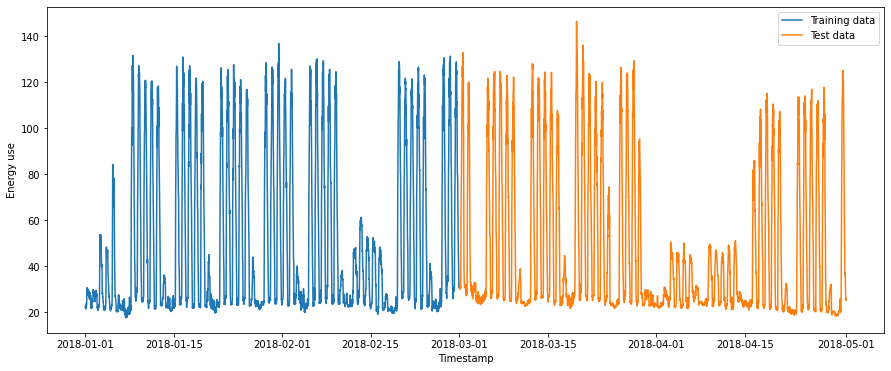

In [6]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(train_data['ts'], train_data['y'], label="Training data")
ax1.plot(test_data['ts'], test_data['y'], label="Test data")
ax1.legend()
plt.xlabel('Timestamp')
plt.ylabel('Energy use')


# Step 3 - Training a forecasting model

Here, we will use a forecasting package called Prophet to train a model to predict energy usage. We will leave out yearly modelling, since we don't have enough data to learn about energy use over a year.

We can use the model to predict future energy use.

In [7]:
!pip install greykite

     |████████████████████████████████| 21.8 MB 33.9 MB/s 
     |████████████████████████████████| 211 kB 38.8 MB/s 
     |████████████████████████████████| 2.7 MB 53.5 MB/s 
     |████████████████████████████████| 95 kB 3.0 MB/s 
     |████████████████████████████████| 41.5 MB 2.3 MB/s 
     |████████████████████████████████| 1.5 MB 44.3 MB/s 
  Attempting uninstall: osqp
    Found existing installation: osqp 0.6.2.post0
    Uninstalling osqp-0.6.2.post0:
      Successfully uninstalled osqp-0.6.2.post0
  Attempting uninstall: plotly
    Found existing installation: plotly 4.14.3
    Uninstalling plotly-4.14.3:
      Successfully uninstalled plotly-4.14.3
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.1.7
    Uninstalling cvxpy-1.1.7:
      Successfully uninstalled cvxpy-1.1.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotly-expres

Adapted from this tutorial: https://towardsdatascience.com/linkedins-response-to-prophet-silverkite-and-greykite-4fd0131f64cb

In [8]:
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [9]:
metadata = MetadataParam(
    time_col="ts",
    value_col="y",
    freq="30T"
)

In [10]:
# creates forecasts and stores the result
forecaster = Forecaster()  

# specify the config
fcst_congig = ForecastConfig(
    model_template=ModelTemplateEnum.SILVERKITE.name,
    forecast_horizon=30,
    coverage=0.95,
    metadata_param=metadata
)

# run the model
result = forecaster.run_forecast_config(
    df=train_data,
    config=fcst_congig
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Text(0, 0.5, 'Energy use')

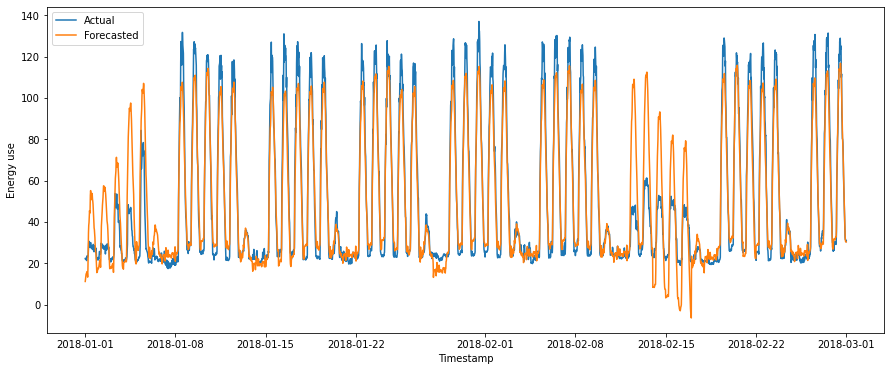

In [11]:
backtest = result.backtest

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(backtest.df['ts'], backtest.df['actual'], label="Actual")
ax1.plot(backtest.df['ts'], backtest.df['forecast'], label="Forecasted")
ax1.legend()
plt.xlabel('Timestamp')
plt.ylabel('Energy use')


In [12]:
# extract the model from the results
model = result.model

# create the future dataframe
future_df = result.timeseries.make_future_dataframe(
    periods=4,
    include_history=False)

# get predictions
forecast = model.predict(test_data)

Text(0, 0.5, 'Energy use')

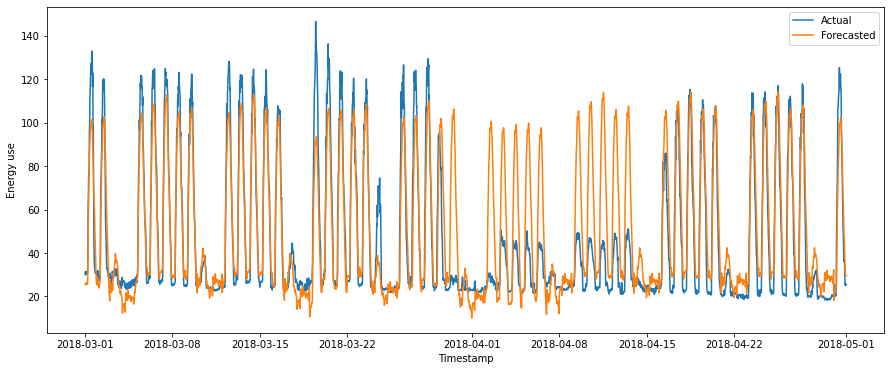

In [13]:
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(test_data['ts'], test_data['y'], label="Actual")
ax1.plot(forecast['ts'], forecast['forecast'], label="Forecasted")
ax1.legend()
plt.xlabel('Timestamp')
plt.ylabel('Energy use')


How about we look at energy usage for the last month from 2018, 2019, 2020 and 2021?

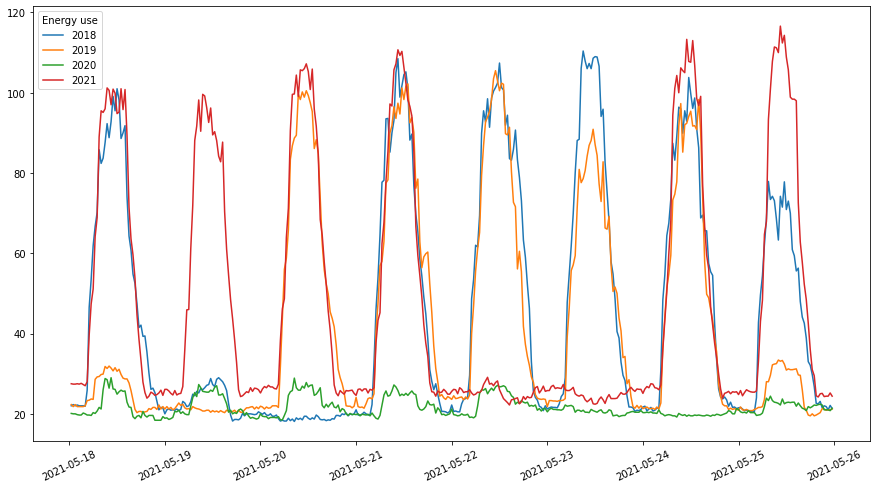

In [14]:
energy['Year'] = energy['Timestamp'].dt.year

energy_month = energy
energy_month['Timestamp'] = energy_month['Timestamp'].mask(energy_month['Timestamp'].dt.year < 2021, energy_month['Timestamp'] + pd.offsets.DateOffset(year=2021))
energy_month = energy_month[(energy_month['Timestamp'] > "2021-05-18") & (energy_month['Timestamp'] < "2021-5-26")]

fig, ax1 = plt.subplots(figsize=(15,8))
plt.xticks( rotation=25 )

groups = energy_month.groupby('Year')
for name, group in groups:
    ax1.plot(group['Timestamp'], group['Energy'], label=name)
ax1.legend(title='Energy use', loc='upper left')
